# **Breast Cancer - Comparative Analysis**

Dataset link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

The following project will focus on finding the architecture with the best metrics (Accuracy, F1 and AUC) for this dataset. The proposed architectures for this experiment are:
* Attention U-Net
* ResNet-34
* VGGNet-16
* Inception V3
* AlexNet

This notebook represents one of the three which will run experiments with images where the Magnification factor is 400x.   


## **Setting the Resources** 

In [40]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
%matplotlib inline

import os
import pathlib
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, ZeroPadding2D, Input, Add, BatchNormalization, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, ReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from sklearn.model_selection import KFold

import cv2 as cv

The current project will make use of one GPU:

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU detected.')
else:
    print(f'Default GPU device: {tf.test.gpu_device_name()}')

Default GPU device: /device:GPU:0


In [4]:
!nvidia-smi

Wed May  4 08:20:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 511.69       Driver Version: 511.69       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   56C    P0    16W /  N/A |    290MiB /  4096MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Multi-class Image Classification: A 5-fold-cross-validation experiment

1. Analysing the data
2. preprocess the data (prepare it for our model, the main step here is scaling/normalizing and turning out data into batches)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our baseline)
7. Repeat until satisfied (experiment, experiment, experiment)

## Inspecting the Data 

In [5]:
num_images = len(os.listdir('BreaKHis_v1/Experimento_1/'))

for dirpath, dirnames, filenames in os.walk('BreaKHis_v1/Experimento_1/'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.')

There are 2 directories and 2 images in BreaKHis_v1/Experimento_1/.
There are 8 directories and 0 images in BreaKHis_v1/Experimento_1/Test.
There are 0 directories and 25 images in BreaKHis_v1/Experimento_1/Test\adenosis.
There are 0 directories and 196 images in BreaKHis_v1/Experimento_1/Test\ductal_carcinoma.
There are 0 directories and 52 images in BreaKHis_v1/Experimento_1/Test\fibroadenoma.
There are 0 directories and 28 images in BreaKHis_v1/Experimento_1/Test\lobular_carcinoma.
There are 0 directories and 39 images in BreaKHis_v1/Experimento_1/Test\mucinous_carcinoma.
There are 0 directories and 32 images in BreaKHis_v1/Experimento_1/Test\papillary_carcinoma.
There are 0 directories and 26 images in BreaKHis_v1/Experimento_1/Test\phyllodes_tumor.
There are 0 directories and 31 images in BreaKHis_v1/Experimento_1/Test\tubular_adenoma.
There are 8 directories and 0 images in BreaKHis_v1/Experimento_1/Train.
There are 0 directories and 78 images in BreaKHis_v1/Experimento_1/Train\a

In [6]:
data_dir_train = pathlib.Path('BreaKHis_v1/Experimento_1/Train/')

# creating a list of class_names from the subdirectory /train
class_names = np.array(sorted([item.name for item in data_dir_train.glob('*')]))
print(f'Types: {class_names}')

Types: ['adenosis' 'ductal_carcinoma' 'fibroadenoma' 'lobular_carcinoma'
 'mucinous_carcinoma' 'papillary_carcinoma' 'phyllodes_tumor'
 'tubular_adenoma']


### Visualizing the Data

In [7]:
# checking the images

def view_random_image(target_dir, target_class):
    # setup the target directory
    target_folder = target_dir + target_class
    
    # get a random image path
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    
    # read in the image and plot using matplotlib
    img = mpimg.imread(target_folder + '/' + random_image[0])
    
    plt.imshow(img)
    plt.title(target_class)
    plt.axis('off')
    
    print(f'Image shape: {img.shape}')
    
    return img

['SOB_B_A-14-22549G-400-014.png']
Image shape: (460, 700, 3)
['SOB_B_F-14-14134E-400-007.png']
Image shape: (460, 700, 3)
['SOB_B_PT-14-22704-400-003.png']
Image shape: (460, 700, 3)
['SOB_B_TA-14-15275-400-004.png']
Image shape: (460, 700, 3)
['SOB_M_DC-14-18650-400-017.png']
Image shape: (460, 700, 3)
['SOB_M_LC-14-13412-400-001.png']
Image shape: (460, 700, 3)
['SOB_M_MC-14-18842D-400-001.png']
Image shape: (460, 700, 3)
['SOB_M_PC-14-9146-400-001.png']
Image shape: (460, 700, 3)


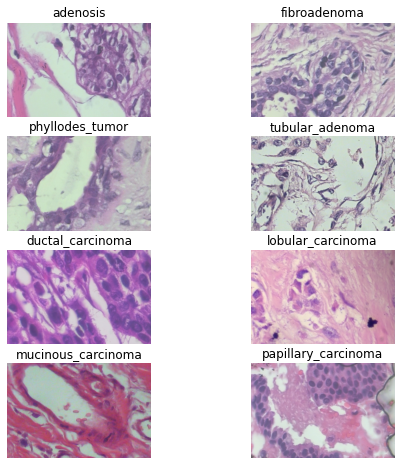

In [8]:
# view a random set of images from the training benign and malign datasets

plt.figure(figsize=(8,8))

plt.subplot(4,2,1)
img1 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='adenosis')

plt.subplot(4,2,2)
img2 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='fibroadenoma')

plt.subplot(4,2,3)
img3 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='phyllodes_tumor')

plt.subplot(4,2,4)
img4 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='tubular_adenoma')

plt.subplot(4,2,5)
img1 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='ductal_carcinoma')

plt.subplot(4,2,6)
img2 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='lobular_carcinoma')

plt.subplot(4,2,7)
img3 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='mucinous_carcinoma')

plt.subplot(4,2,8)
img4 = view_random_image(target_dir='BreaKHis_v1/Experimento_1/Train/', target_class='papillary_carcinoma')

## 2. Preprocess the Data (Prepare it for the experiments)

In [9]:
# setting up the train and test directories

train_dir = 'BreaKHis_v1/Experimento_1/Train/'
test_dir = 'BreaKHis_v1/Experimento_1/Test/'

In [10]:
# normalizing the data
train_datagen = ImageDataGenerator(rescale=1/255., horizontal_flip=True, 
                                   rotation_range=20, vertical_flip=True, width_shift_range=0.2, 
                                   zoom_range=0.2, validation_split=0.3)
#  featurewise_std_normalization=True,
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=128,
                                              class_mode='categorical', shuffle=True, 
                                              subset='training')
validation_data = train_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32,
                                                   class_mode='categorical', shuffle=True,
                                                   subset='validation')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32,
                                            class_mode='categorical')

# (std, mean, and principal components if ZCA whitening is applied)

Found 959 images belonging to 8 classes.
Found 406 images belonging to 8 classes.
Found 429 images belonging to 8 classes.


## 3. Create a Model (start with baselines)

Just a simple model to test our experiments.

In [11]:
# Plotting the validation and training curves separately

def plot_loss_curves(history, network):
    """
    Returns separeted loss curves for training and validation metrics.
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss'])) # how many epochs did we run for?
    
    plt.figure(figsize=(14,4))
    
    # plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='validation_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    
    #plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label='accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    
    plt.suptitle(network, fontsize=14)

### **AlexNet** 

In [12]:
def alexnet(summary = False):
    model = Sequential([
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
        BatchNormalization(),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),

        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),

        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),

        Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(3,3), strides=(2,2)),

        Flatten(),

        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(8, activation='softmax')
    ])
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    if summary:
        model.summary()
    
    return model

### **ResNet-50** 

In [45]:
def resnet50():
    # Download the architecture of ResNet50 with ImageNet weights
    base_model = ResNet50(include_top=False, weights='imagenet')

    # Taking the output of the last convolution block in ResNet50
    x = base_model.output

    # Adding a Global Average Pooling layer
    x = GlobalAveragePooling2D()(x)

    # Adding a fully connected layer having 1024 neurons
    x = Dense(1024, activation='relu')(x)

    # Adding a fully connected layer having 2 neurons which will
    # give the probability of image having either dog or cat
    predictions = Dense(8, activation='softmax')(x)

    # Model to be trained
    model = Model(inputs=base_model.input, outputs=predictions)

    # Training only top layers i.e. the layers which we have added in the end
    for layer in base_model.layers:
        layer.trainable = False

    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    
    return model

## 4. Fit a Model 

In [43]:
def fitting_model(model):
    # patient early stopping
#     es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    history = model.fit(train_data, epochs=5, steps_per_epoch=len(train_data),
                        validation_data=validation_data, validation_steps=len(validation_data)) 
#                         callbacks=[es])
    return history

## 5. Evaluate Models 

94773248/94765736 [==============================] - 5s 0us/step
Epoch 1/5
8/8 [==============================] - 24s 3s/step - loss: 2.0517 - accuracy: 0.3222 - val_loss: 1.9415 - val_accuracy: 0.4335
Epoch 2/5
8/8 [==============================] - 21s 3s/step - loss: 1.8699 - accuracy: 0.4296 - val_loss: 1.7821 - val_accuracy: 0.4335
Epoch 3/5
8/8 [==============================] - 22s 3s/step - loss: 1.8186 - accuracy: 0.4296 - val_loss: 1.7574 - val_accuracy: 0.4335
Epoch 4/5
8/8 [==============================] - 21s 3s/step - loss: 1.7776 - accuracy: 0.4296 - val_loss: 1.7420 - val_accuracy: 0.4335
Epoch 5/5
14/14 [==============================] - 4s 319ms/step - loss: 1.7226 - accuracy: 0.4569


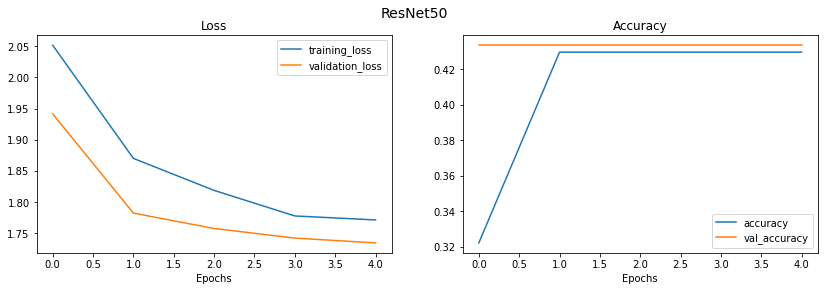

In [46]:
# evaluate on test data

## AlexNet
# model_1 = alexnet()
# history_alexnet = fitting_model(model1)
# loss, acc = model.evaluate(test_data)
# plot_loss_curves(history, "AlexNet")

## ResNet-34
model_2 = resnet50()
history_resnet = fitting_model(model_2)
loss_2, acc_2 = model_2.evaluate(test_data)
plot_loss_curves(history_resnet, "ResNet50")
